In [1]:
#Reference Code: https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/
import warnings
warnings.simplefilter('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

BASE_DIR = '/content/drive/My Drive/Colab Notebooks/CS260D/Project/'
df_original = None
DS_RANDOM = 'Random'
DS_HIGH_ZSCORE = 'High Z-score'
DS_LOW_ZSCORE = 'Low Z-score'
NUMERIC_FEATURES = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [3]:
class Multiclass(nn.Module):
    def __init__(self, hidden_layer_num):
        super().__init__()
        self.hidden = nn.Linear(29, hidden_layer_num)
        self.act = nn.ReLU()
        self.output = nn.Linear(hidden_layer_num, 2)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

# Function: Get the pruned dataset

In [4]:
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import zscore

def get_credit_card_dataset(data_selection, portion_kept):
    global df_original
    if df_original is None:
        # https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023
        df = pd.read_csv(BASE_DIR+'creditcard_2023.csv', sep=',', encoding='utf-8')
        df.drop(['id'], axis=1, inplace=True)
        df_original = df.copy(deep=True)
    else:
        df = df_original.copy(deep=True)

    if data_selection == DS_RANDOM:
        df_random_sample = pd.DataFrame(columns=df.columns)
        for i in df['Class'].unique():
            df_tmp1 = df[df['Class']==i]
            df_tmp2 = df_tmp1.sample(n=int(df_tmp1.shape[0]*portion_kept))
            df_random_sample = pd.concat([df_random_sample, df_tmp2], ignore_index=True)

        df = df_random_sample
    elif data_selection == DS_HIGH_ZSCORE:
        df_zscore = df.apply(zscore).apply(abs)
        series_row_avg = df[NUMERIC_FEATURES].mean(axis=1)
        df_row_avg = pd.DataFrame({'Avg': series_row_avg.values})
        df = df.join(df_row_avg)

        df_high_zscore = df[df['Avg'] > df['Avg'].quantile(1.0-portion_kept)]
        df_high_zscore.drop(['Avg'], axis=1, inplace=True)
        df = df_high_zscore
    elif data_selection == DS_LOW_ZSCORE:
        df_zscore = df.apply(zscore).apply(abs)
        series_row_avg = df[NUMERIC_FEATURES].mean(axis=1)
        df_row_avg = pd.DataFrame({'Avg': series_row_avg.values})
        df = df.join(df_row_avg)

        df_low_zscore = df[df['Avg'] <= df['Avg'].quantile(portion_kept)]
        df_low_zscore.drop(['Avg'], axis=1, inplace=True)
        df = df_low_zscore

    # read data and apply one-hot encoding
    X = df.iloc[:, 0:29]
    y = df.iloc[:, 29:]
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)

    # convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
    X = torch.tensor(X.values, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return X, y

# Function: Trainging of 1 Epoch

In [5]:
import copy
import tqdm
from sklearn.model_selection import train_test_split

def train_one_epoch(X, y, hidden_layer_num, learning_rate, n_epochs, batch_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    model = Multiclass(hidden_layer_num)

    # loss metric and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # prepare model and training parameters
    batches_per_epoch = len(X_train) // batch_size

    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    train_loss_record = []
    train_acc_record = []
    test_loss_record = []
    test_acc_record = []

    # training loop
    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        # set model in training mode and run through each batch
        model.train()
        with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
            bar.set_description(f"Epoch {epoch}")
            for i in bar:
                # take a batch
                start = i * batch_size
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # compute and store metrics
                acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
                epoch_loss.append(float(loss))
                epoch_acc.append(float(acc))
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )

        # set model in evaluation mode and run through the test set
        model.eval()
        y_pred = model(X_test)
        ce = loss_fn(y_pred, y_test)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
        ce = float(ce)
        acc = float(acc)
        train_loss_record.append(np.mean(epoch_loss))
        train_acc_record.append(np.mean(epoch_acc))
        test_loss_record.append(ce)
        test_acc_record.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        # if epoch%10 == 0:
        #     print(f'--- Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%')

    # Restore best model
    model.load_state_dict(best_weights)
    return model, best_acc, train_loss_record, train_acc_record, test_loss_record, test_acc_record

# Function: Generate the plot of the accuracy changes along epochs

In [6]:
import matplotlib.pyplot as plt

def print_lost_n_acc_record(chart_name, train_loss_record, train_acc_record, test_loss_record, test_acc_record):
    # Plot the loss and accuracy
    # plt.plot(train_loss_record, label="train")
    # plt.plot(test_loss_record, label="test")
    # plt.xlabel("epochs")
    # plt.ylabel("cross entropy")
    # plt.legend()
    # plt.show()

    plt.plot(train_acc_record, label="train")
    plt.plot(test_acc_record, label="test")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title(chart_name)
    plt.legend()
    plt.show()
    plt.savefig(f'{BASE_DIR}Plot/{chart_name}.png')

# Function: Train the model with given hyperparameters

In [7]:
def train_model(data_selection, portion):
    X, y = get_credit_card_dataset(data_selection, portion)

    learning_rate_list = [0.1, 0.01]
    epochs_list = [20, 100]
    hidden_layer_list = [8, 10]
    # learning_rate_list = [0.1, 0.01]
    # epochs_list = [2, 3]
    # hidden_layer_list = [6, 8]

    b_best_acc = - np.inf
    b_best_model = None
    b_best_hidden_num = None
    b_best_lr = None
    b_best_epochs = None
    df_ds_results = pd.DataFrame(columns=['Data Selection', 'Params', 'Testing Accuracy %'])
    for lr in learning_rate_list:
        for ep in epochs_list:
            for hidden_num in hidden_layer_list:
                print(f'[Start Training]Hidden Layer:{hidden_num} | LR:{lr} | Epochs: {ep}')
                model, accuracy, train_loss_record, train_acc_record, test_loss_record, test_acc_record = train_one_epoch(X, y, hidden_layer_num=hidden_num, learning_rate=lr, n_epochs=ep, batch_size=1024)
                if b_best_acc < accuracy:
                    b_best_acc = accuracy
                    b_best_model = model
                    b_best_hidden_num = hidden_num
                    b_best_lr = lr
                    b_best_epochs = ep
                print(f'[Finish Training]Hidden Layer:{hidden_num} | LR:{lr} | Epochs: {ep} | Accuracy:{accuracy*100:.1f}%')
                df_ds_results = pd.concat([df_ds_results,
                            pd.DataFrame(data=[[data_selection, '{Hidden Layer:'+str(hidden_num)+', Learning Rate:'+str(lr)+', Epochs:'+str(ep)+'}', str(round(accuracy*100, 4))+'%']],
                            columns=df_ds_results.columns)], ignore_index=True)
                chart_name = ('None' if data_selection is None else data_selection) + ('' if data_selection is None else str(portion)) + '_Hidden_' + str(hidden_num) + '_LR_' + str(lr) + '_Epochs_' + str(ep)
                print_lost_n_acc_record(chart_name, train_loss_record, train_acc_record, test_loss_record, test_acc_record)

    print('==================================================')
    print(f'Best Model - Accuracy:{b_best_acc*100:.1f}% | Hidden Layer:{b_best_hidden_num} | LR:{b_best_lr} | Epochs: {b_best_epochs}')
    return b_best_acc, b_best_hidden_num, b_best_lr, b_best_epochs, df_ds_results

# Function: Main function

*** Start: Random 20%
[Start Training]Hidden Layer:8 | LR:0.1 | Epochs: 100


Epoch 99: 100%|██████████| 77/77 [00:00<00:00, 134.63batch/s, acc=0.559, loss=0.691]


[Finish Training]Hidden Layer:8 | LR:0.1 | Epochs: 100 | Accuracy:50.0%


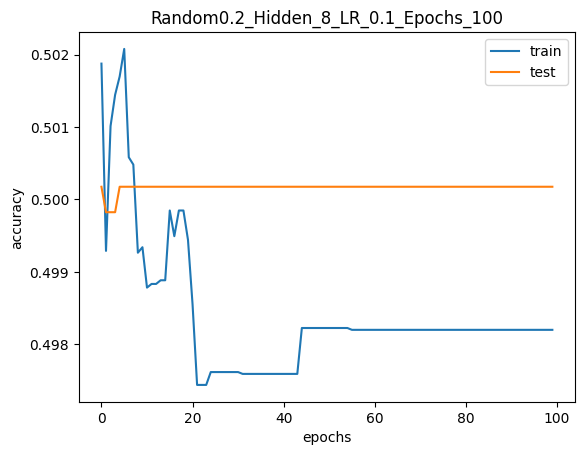

[Start Training]Hidden Layer:10 | LR:0.1 | Epochs: 100


Epoch 99: 100%|██████████| 77/77 [00:00<00:00, 138.53batch/s, acc=0.494, loss=0.694]


[Finish Training]Hidden Layer:10 | LR:0.1 | Epochs: 100 | Accuracy:50.1%


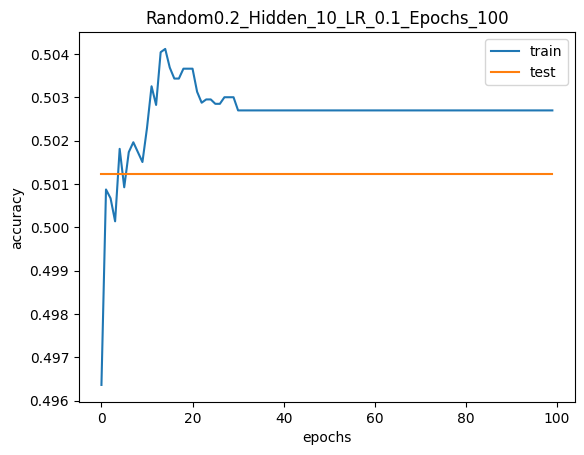

[Start Training]Hidden Layer:8 | LR:0.01 | Epochs: 100


Epoch 99: 100%|██████████| 77/77 [00:00<00:00, 143.85batch/s, acc=0.96, loss=0.106]


[Finish Training]Hidden Layer:8 | LR:0.01 | Epochs: 100 | Accuracy:96.2%


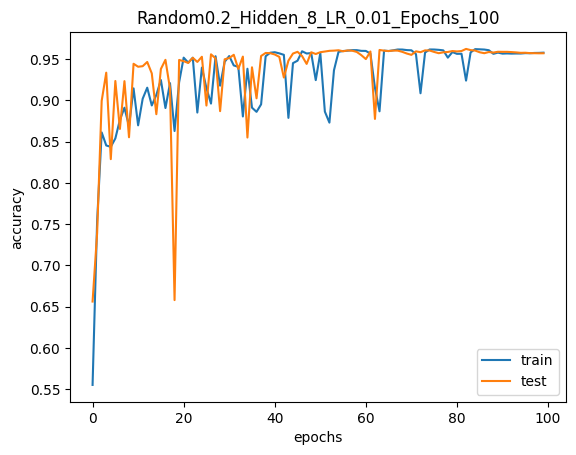

[Start Training]Hidden Layer:10 | LR:0.01 | Epochs: 100


Epoch 99: 100%|██████████| 77/77 [00:00<00:00, 149.16batch/s, acc=0.968, loss=0.0965]


[Finish Training]Hidden Layer:10 | LR:0.01 | Epochs: 100 | Accuracy:96.3%


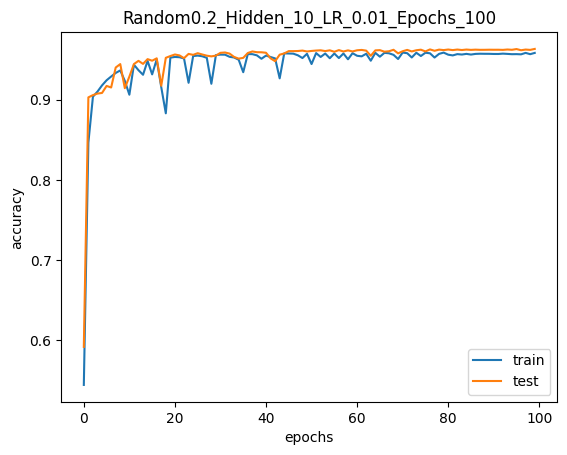

Best Model - Accuracy:96.3% | Hidden Layer:10 | LR:0.01 | Epochs: 100
*** Start: Random 80%
[Start Training]Hidden Layer:8 | LR:0.1 | Epochs: 100


Epoch 99: 100%|██████████| 310/310 [00:01<00:00, 163.75batch/s, acc=0.482, loss=0.693]


[Finish Training]Hidden Layer:8 | LR:0.1 | Epochs: 100 | Accuracy:50.1%


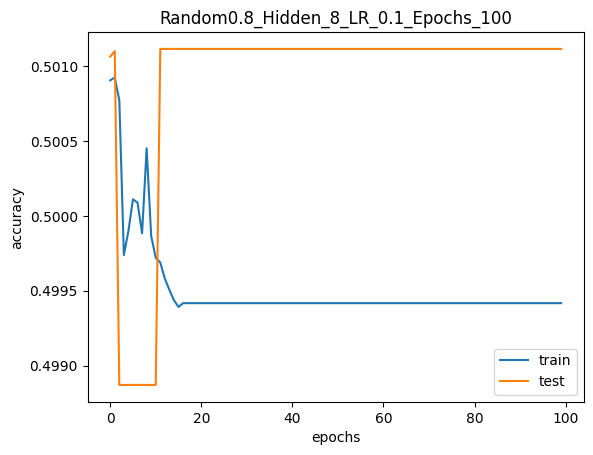

[Start Training]Hidden Layer:10 | LR:0.1 | Epochs: 100


Epoch 99: 100%|██████████| 310/310 [00:01<00:00, 179.50batch/s, acc=0.506, loss=0.693]


[Finish Training]Hidden Layer:10 | LR:0.1 | Epochs: 100 | Accuracy:50.2%


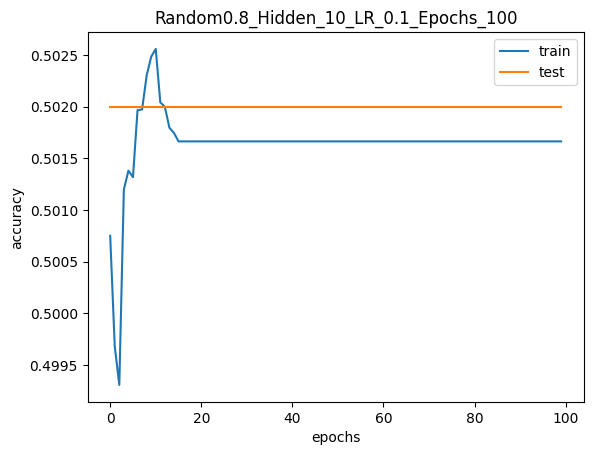

[Start Training]Hidden Layer:8 | LR:0.01 | Epochs: 100


Epoch 99: 100%|██████████| 310/310 [00:01<00:00, 169.35batch/s, acc=0.963, loss=0.101]


[Finish Training]Hidden Layer:8 | LR:0.01 | Epochs: 100 | Accuracy:96.3%


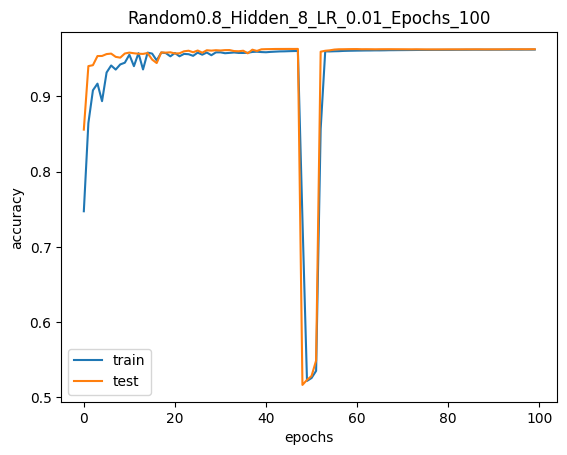

[Start Training]Hidden Layer:10 | LR:0.01 | Epochs: 100


Epoch 99: 100%|██████████| 310/310 [00:01<00:00, 172.80batch/s, acc=0.957, loss=0.105]


[Finish Training]Hidden Layer:10 | LR:0.01 | Epochs: 100 | Accuracy:96.4%


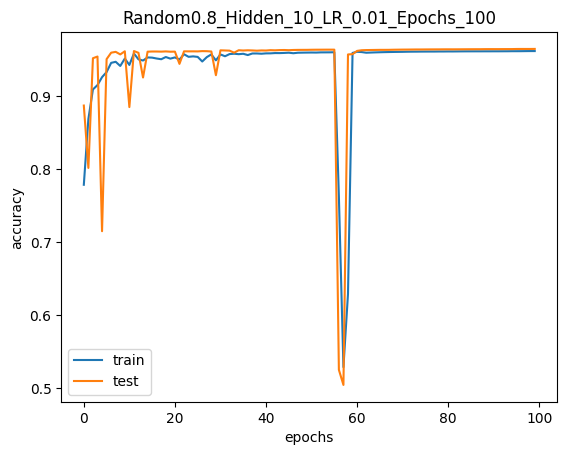

Best Model - Accuracy:96.4% | Hidden Layer:10 | LR:0.01 | Epochs: 100
*** Start: High Z-score 20%
[Start Training]Hidden Layer:8 | LR:0.1 | Epochs: 100


Epoch 99: 100%|██████████| 77/77 [00:00<00:00, 173.55batch/s, acc=0.48, loss=0.693]


[Finish Training]Hidden Layer:8 | LR:0.1 | Epochs: 100 | Accuracy:50.1%


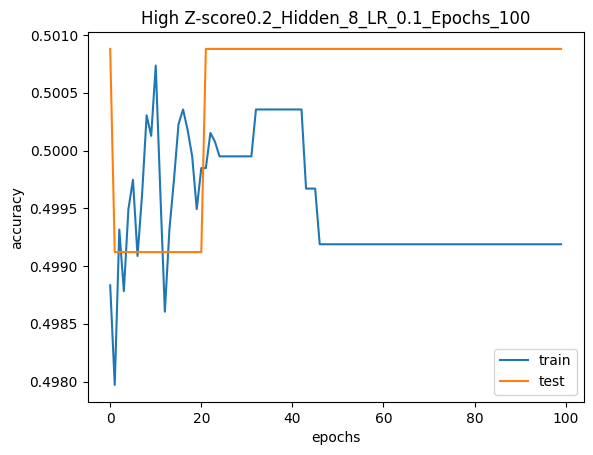

[Start Training]Hidden Layer:10 | LR:0.1 | Epochs: 100


Epoch 99: 100%|██████████| 77/77 [00:00<00:00, 137.69batch/s, acc=0.479, loss=0.695]


[Finish Training]Hidden Layer:10 | LR:0.1 | Epochs: 100 | Accuracy:50.3%


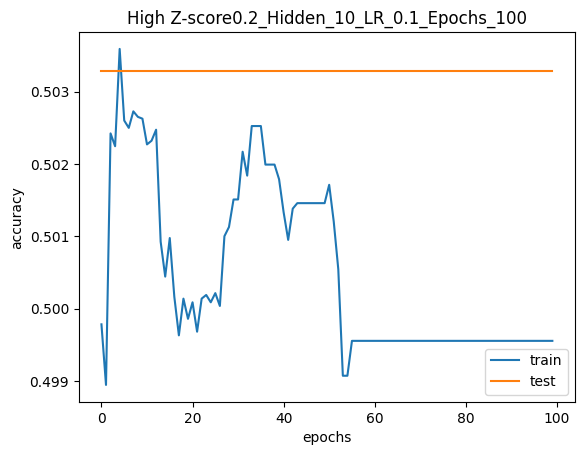

[Start Training]Hidden Layer:8 | LR:0.01 | Epochs: 100


Epoch 99: 100%|██████████| 77/77 [00:00<00:00, 183.59batch/s, acc=0.513, loss=0.693]


[Finish Training]Hidden Layer:8 | LR:0.01 | Epochs: 100 | Accuracy:96.0%


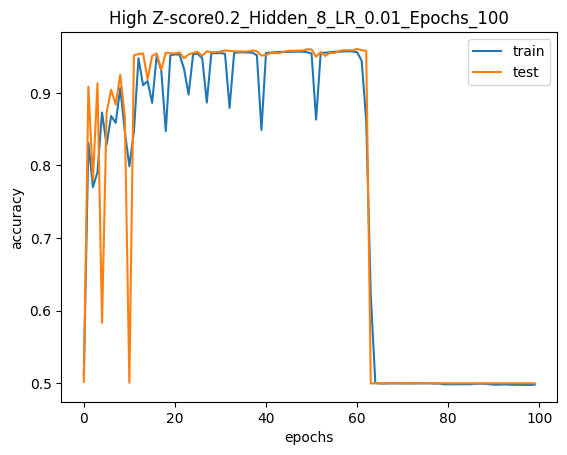

[Start Training]Hidden Layer:10 | LR:0.01 | Epochs: 100


Epoch 99: 100%|██████████| 77/77 [00:00<00:00, 177.97batch/s, acc=0.523, loss=0.693]


[Finish Training]Hidden Layer:10 | LR:0.01 | Epochs: 100 | Accuracy:96.0%


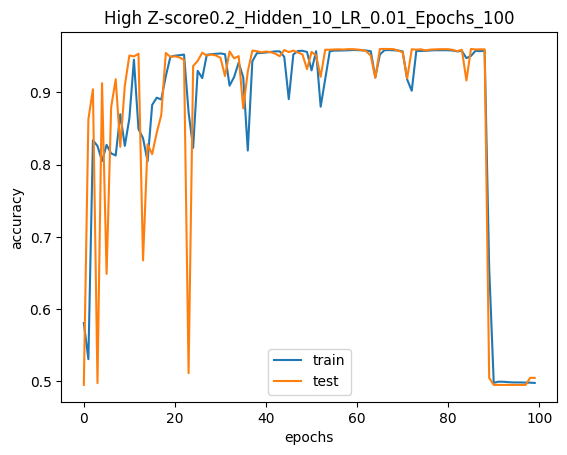

Best Model - Accuracy:96.0% | Hidden Layer:8 | LR:0.01 | Epochs: 100
*** Start: High Z-score 50%
[Start Training]Hidden Layer:8 | LR:0.1 | Epochs: 100


Epoch 99: 100%|██████████| 194/194 [00:01<00:00, 184.44batch/s, acc=0.488, loss=0.693]


[Finish Training]Hidden Layer:8 | LR:0.1 | Epochs: 100 | Accuracy:50.2%


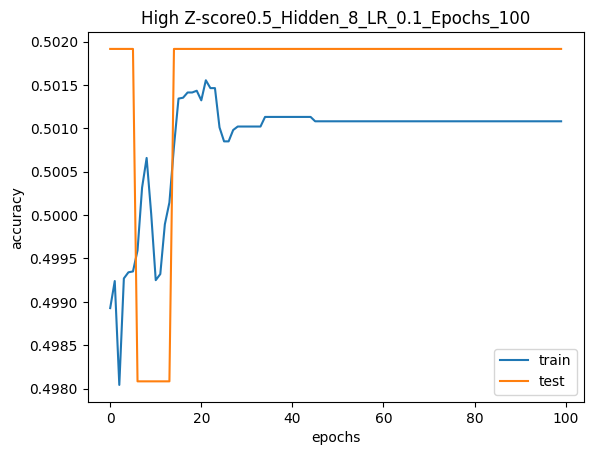

[Start Training]Hidden Layer:10 | LR:0.1 | Epochs: 100


Epoch 99: 100%|██████████| 194/194 [00:01<00:00, 142.63batch/s, acc=0.481, loss=0.694]


[Finish Training]Hidden Layer:10 | LR:0.1 | Epochs: 100 | Accuracy:50.1%


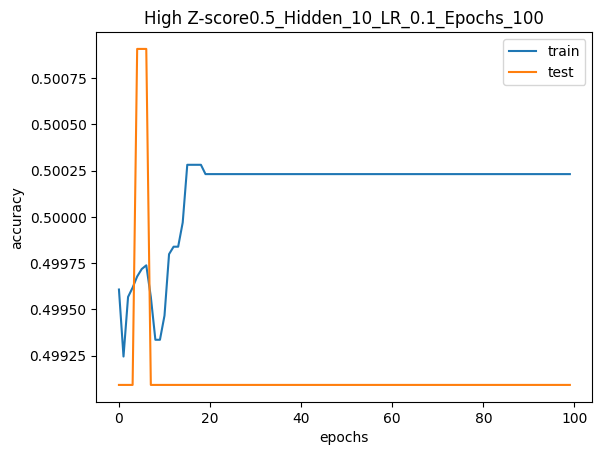

[Start Training]Hidden Layer:8 | LR:0.01 | Epochs: 100


Epoch 28:  84%|████████▍ | 163/194 [00:01<00:00, 129.83batch/s, acc=0.945, loss=0.167]

In [8]:
df_results = pd.DataFrame(columns=['Data Selection', 'Params', 'Testing Accuracy %'])
param_dict = [
            {'name': 'Full', 'data_selection': None, 'portion_kept': None},
              {'name': 'Random 20%', 'data_selection': DS_RANDOM, 'portion_kept': 0.2},
              {'name': 'Random 50%', 'data_selection': DS_RANDOM, 'portion_kept': 0.5},
              {'name': 'Random 80%', 'data_selection': DS_RANDOM, 'portion_kept': 0.8},
              {'name': 'High Z-score 20%', 'data_selection': DS_HIGH_ZSCORE, 'portion_kept': 0.2},
              {'name': 'High Z-score 50%', 'data_selection': DS_HIGH_ZSCORE, 'portion_kept': 0.5},
              {'name': 'High Z-score 80%', 'data_selection': DS_HIGH_ZSCORE, 'portion_kept': 0.8},
              {'name': 'Low Z-score 20%', 'data_selection': DS_LOW_ZSCORE, 'portion_kept': 0.2},
              {'name': 'Low Z-score 50%', 'data_selection': DS_LOW_ZSCORE, 'portion_kept': 0.5},
              {'name': 'Low Z-score 80%', 'data_selection': DS_LOW_ZSCORE, 'portion_kept': 0.8}
              ]

for param in param_dict:
    print('*** Start:', param['name'])
    best_acc, best_hidden_num, best_lr, best_epochs, df_ds_results = train_model(param['data_selection'], param['portion_kept'])
    df_results = pd.concat([df_results,
                            pd.DataFrame(data=[[param['name'], '{Hidden Layer:'+str(best_hidden_num)+', Learning Rate:'+str(best_lr)+', Epochs:'+str(best_epochs)+'}', str(round(best_acc*100, 4))+'%']],
                            columns=df_results.columns)], ignore_index=True)
    df_results.to_csv(BASE_DIR+'Credit_Card_Result_'+param['name']+'_Backup.csv', encoding='utf-8')
    df_ds_results.to_csv(BASE_DIR+'Credit_Card_Result_'+param['name']+'_Log.csv', encoding='utf-8')
    print('====================================================================================================')
    print('====================================================================================================')

In [9]:
df_results

In [10]:
df_results.to_csv(BASE_DIR+'Credit_Card_Result.csv', encoding='utf-8')